## inference in simple model using synthetic data
population size 10^4

we run several independent computations on different data sets, as a test of whether inferred parameters are reliable

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
import os
import pickle
import pprint
import time

import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

import synth_fns

(cell 3 was removed to hide local file info)
### main settings

In [4]:
## for dataFiles : needs a fresh value in every notebooke
fileRoot = 'dataSynthInfQuality-pop1e4'

## total population
popN = 1e4

## tau-leaping param, take this negative to force gillespie
## or set a small value for high-accuracy tau-leap (eg 1e-4 or 1e-5)
leapEps = -1

## do we use small tolerances for the likelihood computations? (use False for debug etc)
isHighAccuracy = True

# absolute tolerance for logp for MAP 
inf_atol = 0.1

## prior mean of beta, divided by true value (set to 1.0 for the simplest case)
betaPriorOffset = 1.0
betaPriorLogNorm = False

## mcmc
mcSamples = 4000
nProcMCMC = 2 # None ## take None to use default but large numbers are not efficient in this example

## how many synthetic trajectories
nTraj = 8

### model

In [5]:
model_dict = synth_fns.get_model(popN)

model_spec = model_dict['mod']
contactMatrix = model_dict['CM']
parameters_true = model_dict['params']
cohortsM = model_dict['cohortsM']
Ni = model_dict['cohortsPop']

trajSeed = 18
infSeed = 21

#### more settings

In [6]:
## total trajectory time (bare units)
Tf_bare = 20
## total inf time
Tf_inf_bare = 5

## inference period starts when the total deaths reach this amount (as a fraction)
fracDeaths = 2e-3 # int(N*200/1e5)


In [7]:
## hack to get higher-frequency data
## how many data points per "timestep" (in original units)
fineData = 4

## this assumes that all parameters are rates !!
for key in parameters_true:
    #print(key,parameters_true[key])
    parameters_true[key] /= fineData

Tf = Tf_bare * fineData;  
Nf = Tf+1

Tf_inference = Tf_inf_bare * fineData
Nf_inference = Tf_inference+1

### plotting helper functions

In [8]:
def plotTraj(M,data_array,Nf_start,Tf_inference,fineData):
    fig = plt.figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    # plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    plt.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    plt.legend()
    plt.show()

    fig,axs = plt.subplots(1,2, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
    ax = axs[0]
    ax.plot(t[1:],np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)),'o-',label='death increments', lw=1)
    ax.legend(loc='upper right') ; # plt.show()

    ax = axs[1]
    ax.plot(t,np.sum(data_array[:, 3*M:4*M], axis=1),'o-',label='deaths',ms=3)
    ax.legend() ; 

    plt.show()


def plotMAP(res,data_array,M,N,estimator,Nf_start,Tf_inference,fineData):
    print('**beta(bare units)',res['params_dict']['beta']*fineData)
    print('**logLik',res['log_likelihood'],'true was',logpTrue)
    print('\n')
    print(res)

    fig,axs = plt.subplots(1,3, figsize=(15, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.subplots_adjust(wspace=0.3)
    #plt.rc('text', usetex=True)
    plt.rc('font', family='serif', size=12)
    t = np.linspace(0, Tf/fineData, Nf)

    ax = axs[0]

    #plt.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='S', lw=4)
    ax.plot(t, np.sum(data_array[:, M:2*M], axis=1), 'o', label='Exposed', lw=2)
    ax.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), 'o', label='Infected', lw=2)
    ax.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), 'o', label='Deaths', lw=2)
    #plt.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=2)

    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    #plt.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', color='C0',label='E-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', color='C1',label='I-MAP', lw=2, ms=3)
    ax.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', color='C2',label='D-MAP', lw=2, ms=3)
    #plt.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-o', label='R-MAP', lw=2)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[1]
    ax.plot(t[1:], np.diff(np.sum(data_array[:, 3*M:4*M], axis=1)), '-o', label='death incs', lw=2)
    ax.plot(tt[1:], np.diff(np.sum(xm[:, 3*M:4*M], axis=1)), '-x', label='MAP', lw=2, ms=3)
    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()

    ax = axs[2]

    ax.plot(t, np.sum(data_array[:, :M], axis=1), '-o', label='Sus', lw=1.5, ms=3)
    #plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-o', label='Exposed', lw=2)
    #plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-o', label='Infected', lw=2)
    #plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-o', label='Deaths', lw=2)
    ax.plot(t, N-np.sum(data_array[:, 0:4*M], axis=1), '-o', label='Rec', lw=1.5, ms=3)

    #infResult = res
    tt = np.linspace(Nf_start, Tf, Nf-Nf_start,)/fineData
    xm = estimator.integrate(res['x0'], Nf_start, Tf, Nf-Nf_start, dense_output=False)
    ax.plot(tt, np.sum(xm[:, :M], axis=1), '-x', label='S-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, M:2*M], axis=1), '-x', label='E-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 2*M:3*M], axis=1), '-x', label='I-MAP', lw=2, ms=3)
    #plt.plot(tt, np.sum(xm[:, 3*M:4*M], axis=1), '-x', label='D-MAP', lw=2, ms=3)
    ax.plot(tt, N-np.sum(xm[:, :4*M], axis=1), '-x', label='R-MAP', lw=1.5, ms=3)

    ax.axvspan(Nf_start/fineData, (Nf_start+Tf_inference)/fineData,alpha=0.3, color='dodgerblue')
    ax.legend()
    plt.show()
    

    
def plotMCtrace(selected_dims, sampler, numTrace=None):
    # Plot the trace for these dimensions:
    plot_dim = len(selected_dims)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(plot_dim, figsize=(12, plot_dim), sharex=True)
    samples = sampler.get_chain()
    if numTrace == None : numTrace = np.shape(samples)[1]  ## corrected index
    for ii,dd in enumerate(selected_dims):
        ax = axes[ii]
        ax.plot(samples[:, :numTrace , dd], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
    axes[-1].set_xlabel("step number");
    plt.show(fig)
    plt.close()

def plotPosteriors(estimator,obsData, fltrDeath, Tf_inference,param_priors, init_priors,contactMatrix,
                   infResult,parameters_true,trueInit,rangeParam=0.5) :
    ## used for prior pdfs
    (likFun,priFun,dimFlat) = pyross.evidence.latent_get_parameters(estimator,
                                        obsData, fltrDeath, Tf_inference,
                                        param_priors, init_priors,                                   
                                        contactMatrix,
                                        #intervention_fun=interventionFn,
                                        tangent=False,
                                      )
    xVals = np.linspace(parameters_true['beta']*(1-rangeParam),parameters_true['beta']*(1+rangeParam),100)

    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    plt.hist(betas,density=True,color='lightblue',label='posterior')
    yVal=2
    plt.plot([infResult['params_dict']['beta']],[yVal],'bs',label='MAP',ms=10)
    plt.plot([parameters_true['beta']],[yVal],'ro',label='true',ms=10)


    ## this is a bit complicated, it just finds the prior for beta from the infResult
    var='beta'
    jj = infResult['param_keys'].index(var)
    xInd = infResult['param_guess_range'][jj]
    #print(jj,xInd)
    pVals = []
    for xx in xVals :
        flatP = np.zeros( dimFlat )
        flatP[xInd] = xx
        pdfAll = np.exp( priFun.logpdf(flatP) )
        pVals.append( pdfAll[xInd] )
    plt.plot(xVals,pVals,color='darkgreen',label='prior')


    plt.xlabel(var)
    plt.ylabel('pdf')
    plt.legend()

    labs=['init S','init E','init I']
    nPanel=3
    fig,axs = plt.subplots(1,nPanel,figsize=(14,4))
    for ii in range(nPanel) :   
        ax = axs[ii]
        yVal=1.0/popN
        xs = [ rr['x0'][ii] for rr in result_mcmc ]
        ax.hist(xs,color='lightblue',density=True)
        ax.plot([infResult['x0'][ii]],yVal,'bs',label='true')
        ax.plot([trueInit[ii]],yVal,'ro',label='true')


        ## this is a bit complicated, it just finds the prior for beta from the infResult
        ## axis ranges
        xMin = np.min(xs)*0.8
        xMax = np.max(xs)*1.2
        xVals = np.linspace(xMin,xMax,100)

        ## this ID is a negative number because the init params are the end of the 'flat' param array
        paramID = ii-nPanel 
        pVals = []
        for xx in xVals :
            flatP = np.zeros( dimFlat )
            flatP[paramID] = xx
            pdfAll = np.exp( priFun.logpdf(flatP) )
            pVals.append( pdfAll[paramID] )
        ax.plot(xVals,pVals,color='darkgreen',label='prior')

        #plt.xlabel(var)
        ax.set_xlabel(labs[ii])
        ax.set_ylabel('pdf')
        ax.yaxis.set_ticklabels([])

    plt.show()


### run

trajSeed 19
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 19}
traj generation time 0.8973193168640137 secs
inf starts at timePoint 24
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=22, Fri Apr 30 22:25:15 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.329214516241197e+01 1.0e+00 1.05e+00  1e-02  3e+02 0:03.8
    2    128 6.319303501538992e+01 1.7e+00 9.33e-01  9e-03  3e+02 0:07.8
    3    192 6.300010158137195e+01 2.3e+00 9.19e-01  7e-03  2e+02 0:11.5
    4    256 6.305033934202979e+01 2.9e+00 8.94e-01  5e-03  2e+02 0:15.5
    6    384 6.292137394440087e+01 2.7e+00 8.91e-01  3e-03  1e+02 0:23.2
    8    512 6.291743453256781e+01 2.8e+00 8.18e-01  2e-03  5e+01 0:31.0
   10    640 6.290852041261250e+01 3.2e+00 6.78e-01  7e-04  2e+01 0:38.5
   12    768 6.290726491447948e+01 2.9e+00 6.43e-01  4e-04  1e+01 0:45.9
   15    960 6.29066

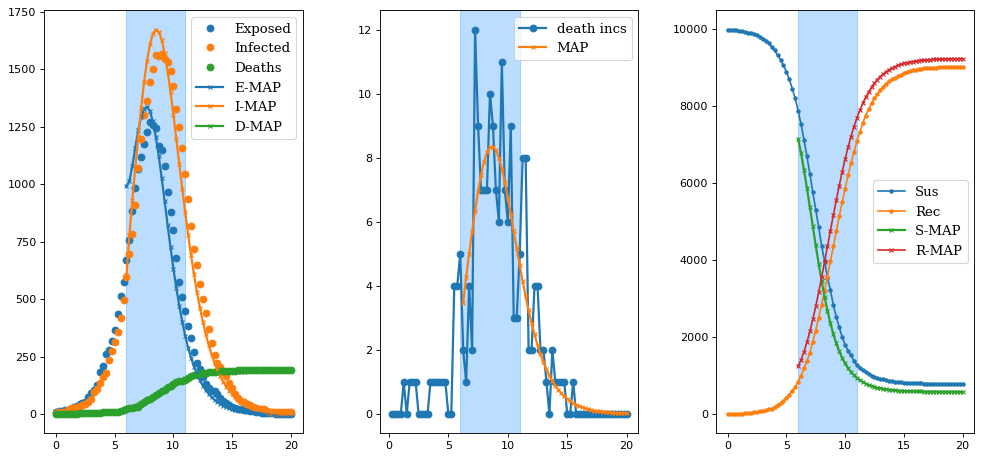

trajSeed 20
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 20}
traj generation time 0.7795584201812744 secs
inf starts at timePoint 25
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=23, Fri Apr 30 22:26:15 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.554032619146126e+01 1.0e+00 1.06e+00  1e-02  3e+02 0:03.8
    2    128 6.561854544996740e+01 1.5e+00 1.07e+00  9e-03  2e+02 0:07.6
    3    192 6.551818706924368e+01 1.9e+00 1.07e+00  6e-03  2e+02 0:11.4
    4    256 6.542720722124469e+01 2.5e+00 9.54e-01  4e-03  2e+02 0:15.3
    6    384 6.534849105154362e+01 3.0e+00 7.51e-01  2e-03  7e+01 0:22.7
    8    512 6.534593784241076e+01 3.4e+00 5.56e-01  8e-04  3e+01 0:30.3
   10    640 6.534248172352507e+01 4.0e+00 5.38e-01  4e-04  2e+01 0:37.7
   12    768 6.534261468173361e+01 4.3e+00 4.26e-01  2e-04  8e+00 0:45.3
   14    896 6.53422

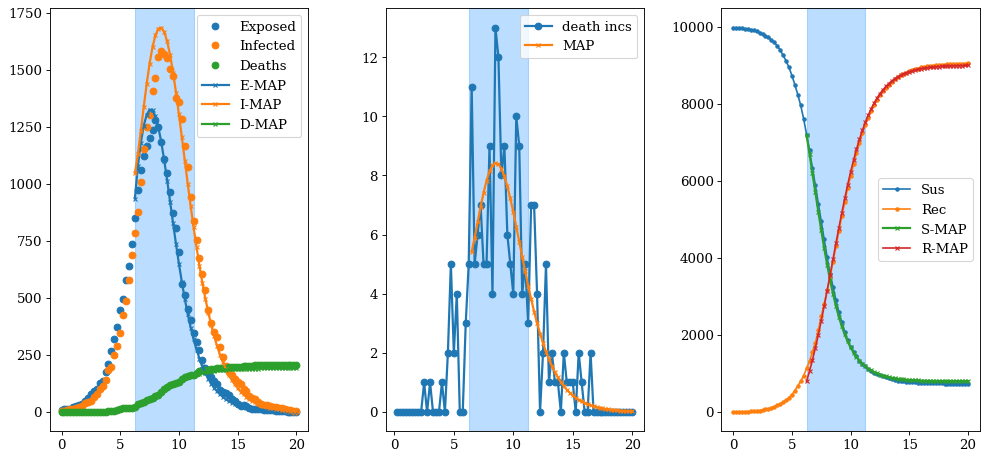

trajSeed 21
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 21}
traj generation time 0.5084037780761719 secs
inf starts at timePoint 28
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=24, Fri Apr 30 22:27:09 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.444943238650839e+01 1.0e+00 9.52e-01  1e-02  3e+02 0:03.8
    2    128 6.453983146654141e+01 1.5e+00 8.19e-01  8e-03  2e+02 0:07.6
    3    192 6.429240950622474e+01 2.1e+00 9.17e-01  6e-03  2e+02 0:11.4
    4    256 6.440515425445588e+01 3.0e+00 9.29e-01  5e-03  2e+02 0:15.1
    6    384 6.428460041908288e+01 3.3e+00 7.29e-01  2e-03  7e+01 0:22.9
    8    512 6.427071447541121e+01 3.5e+00 6.15e-01  9e-04  4e+01 0:30.5
   10    640 6.427004652528888e+01 4.2e+00 5.65e-01  4e-04  2e+01 0:38.0
   12    768 6.426938837331542e+01 3.6e+00 4.68e-01  2e-04  9e+00 0:45.6
   15    960 6.42690

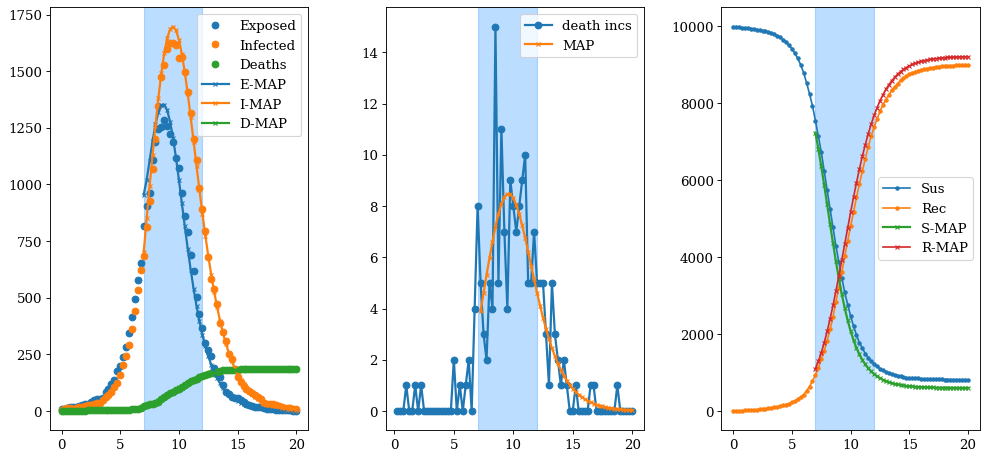

trajSeed 22
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 22}
traj generation time 0.8820154666900635 secs
inf starts at timePoint 28
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=25, Fri Apr 30 22:28:08 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.144136288102123e+01 1.0e+00 9.40e-01  1e-02  3e+02 0:03.7
    2    128 6.131167427867230e+01 1.4e+00 8.78e-01  8e-03  2e+02 0:07.5
    3    192 6.134787049620011e+01 1.7e+00 7.74e-01  5e-03  1e+02 0:11.3
    4    256 6.129199977474862e+01 2.3e+00 6.98e-01  3e-03  1e+02 0:15.1
    6    384 6.123297809464825e+01 2.6e+00 7.44e-01  3e-03  8e+01 0:22.8
    8    512 6.120929174388867e+01 3.7e+00 6.52e-01  1e-03  4e+01 0:30.4
   10    640 6.120683887495232e+01 4.1e+00 5.36e-01  5e-04  2e+01 0:37.9
   12    768 6.120646758970608e+01 4.0e+00 4.44e-01  2e-04  9e+00 0:45.5
   14    896 6.12061

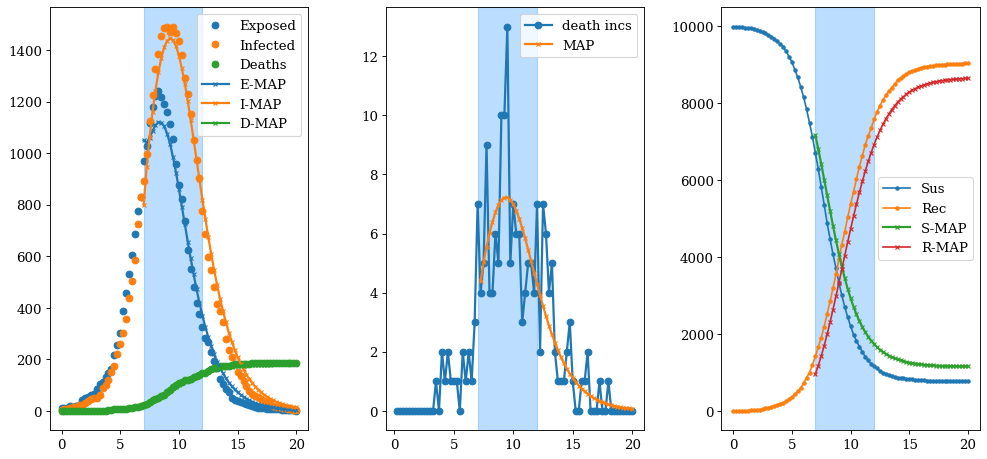

trajSeed 23
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 23}
traj generation time 0.5969183444976807 secs
inf starts at timePoint 27
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=26, Fri Apr 30 22:29:03 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.388034758501527e+01 1.0e+00 9.30e-01  1e-02  3e+02 0:03.5
    2    128 6.387045512939839e+01 1.5e+00 8.95e-01  8e-03  2e+02 0:07.4
    3    192 6.369748219229460e+01 1.9e+00 8.53e-01  6e-03  2e+02 0:11.4
    4    256 6.361967930999742e+01 2.3e+00 8.32e-01  4e-03  1e+02 0:15.2
    6    384 6.363698740799538e+01 3.1e+00 7.24e-01  2e-03  7e+01 0:23.0
    8    512 6.361762661784604e+01 3.6e+00 5.67e-01  9e-04  3e+01 0:30.6
   10    640 6.361364401740147e+01 3.7e+00 5.55e-01  5e-04  2e+01 0:38.1
   12    768 6.361333738172700e+01 3.7e+00 4.43e-01  2e-04  8e+00 0:45.7
   13    832 6.36131

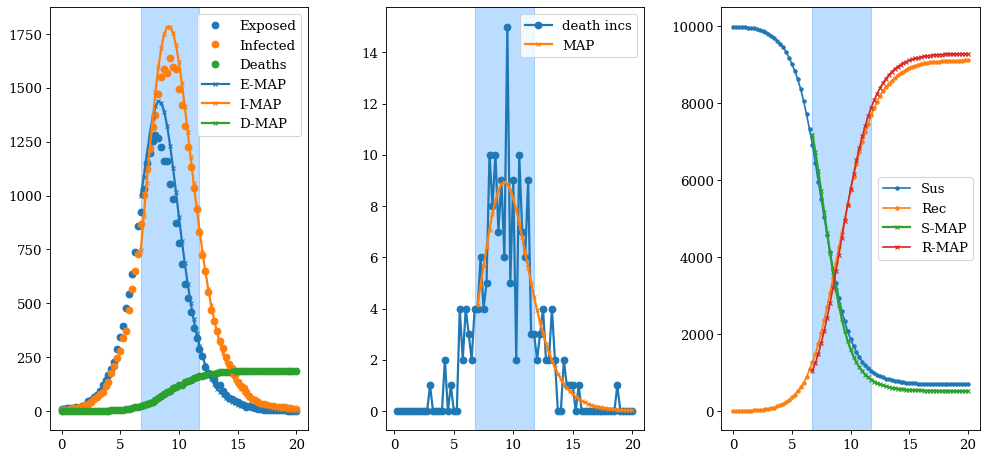

trajSeed 24
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 24}
traj generation time 0.6717369556427002 secs
inf starts at timePoint 27
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=27, Fri Apr 30 22:29:56 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.138474242465175e+01 1.0e+00 9.13e-01  1e-02  3e+02 0:03.8
    2    128 6.111401816152134e+01 1.5e+00 8.32e-01  7e-03  2e+02 0:07.6
    3    192 6.099685623828244e+01 2.1e+00 8.39e-01  5e-03  2e+02 0:11.4
    4    256 6.098431305234576e+01 2.7e+00 7.80e-01  4e-03  1e+02 0:15.1
    6    384 6.093415944522168e+01 2.9e+00 6.86e-01  2e-03  7e+01 0:22.6
    8    512 6.092091477401476e+01 3.5e+00 6.62e-01  9e-04  4e+01 0:30.0
   10    640 6.091561317063032e+01 3.6e+00 5.80e-01  5e-04  2e+01 0:37.6
   12    768 6.091418258064125e+01 3.5e+00 5.14e-01  2e-04  1e+01 0:45.2
   13    832 6.09139

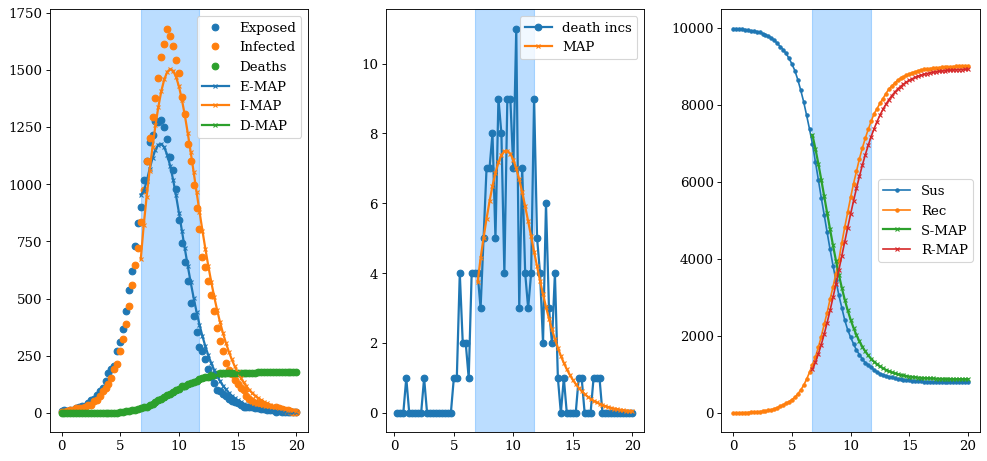

trajSeed 25
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 25}
traj generation time 0.7209503650665283 secs
inf starts at timePoint 26
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=28, Fri Apr 30 22:30:47 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 6.598031670761588e+01 1.0e+00 8.91e-01  1e-02  2e+02 0:03.7
    2    128 6.559292132312312e+01 1.4e+00 8.61e-01  7e-03  2e+02 0:07.7
    3    192 6.549812423677793e+01 1.9e+00 7.94e-01  5e-03  2e+02 0:11.6
    4    256 6.546879894902887e+01 2.5e+00 7.47e-01  3e-03  1e+02 0:15.4
    6    384 6.546832450243986e+01 3.4e+00 6.12e-01  1e-03  5e+01 0:23.1
    8    512 6.546127042572672e+01 3.6e+00 4.80e-01  6e-04  2e+01 0:30.7
   10    640 6.545955627129581e+01 3.3e+00 3.67e-01  3e-04  9e+00 0:38.3
   12    768 6.545926349207073e+01 3.1e+00 3.46e-01  1e-04  4e+00 0:45.8
   13    832 6.54592

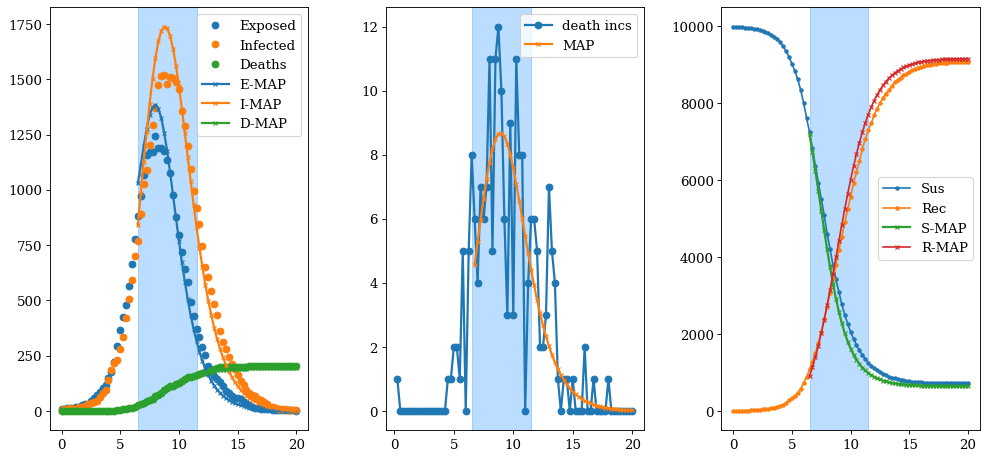

trajSeed 26
{'beta': 0.035, 'gE': 0.35000000000000003, 'gR': 0.245, 'gD': 0.005, 'seed': 26}
traj generation time 0.6382381916046143 secs
inf starts at timePoint 27
setting high-accuracy for likelihood
Starting global minimisation ...
(32_w,64)-aCMA-ES (mu_w=17.6,w_1=11%) in dimension 4 (seed=29, Fri Apr 30 22:31:39 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     64 5.964434796668308e+01 1.0e+00 9.40e-01  1e-02  3e+02 0:03.7
    2    128 5.964420881256261e+01 1.6e+00 8.03e-01  6e-03  2e+02 0:07.6
    3    192 5.953832493072294e+01 2.0e+00 7.85e-01  4e-03  2e+02 0:11.4
    4    256 5.949253218515150e+01 2.6e+00 7.22e-01  3e-03  1e+02 0:15.3
    6    384 5.945278001240163e+01 2.6e+00 5.61e-01  1e-03  5e+01 0:23.0
    8    512 5.944764825833434e+01 3.2e+00 4.43e-01  6e-04  2e+01 0:30.5
   10    640 5.944724813566920e+01 3.6e+00 3.84e-01  2e-04  1e+01 0:38.0
   12    768 5.944723625089945e+01 3.6e+00 3.55e-01  1e-04  6e+00 0:45.5
   13    832 5.94472

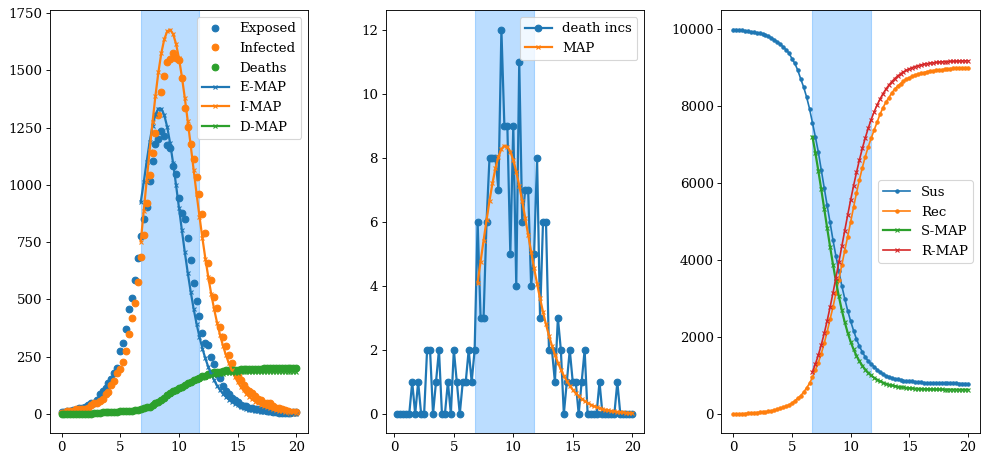

In [9]:
allData = []
allResultsInf = []

for trajIndex in range(nTraj) :
    
    trajSeed += 1
    infSeed += 1
    #mcSeed += 1
    print('trajSeed',trajSeed)
    
    ticTime = time.time()
    syntheticData = synth_fns.make_stochastic_traj(Tf,Nf,trajSeed,model_dict,leapEps)
    tocTime = time.time() - ticTime
    print('traj generation time',tocTime,'secs')

    np.save(fileRoot+'-stochTraj.npy',syntheticData)

    Nf_start = synth_fns.get_start_time(syntheticData, popN, fracDeaths)
    print('inf starts at timePoint',Nf_start)

    #plotTraj(cohortsM,syntheticData,Nf_start,Tf_inference,fineData)


    [estimator,fltrDeath,obsData,trueInit] = synth_fns.get_estimator(isHighAccuracy,model_dict,syntheticData, popN, Nf_start, Nf_inference,)

    allData += [obsData]
    
    ## compute log-likelihood of true params
    logpTrue = -estimator.minus_logp_red(parameters_true, trueInit, obsData, fltrDeath, Tf_inference, 
                                         contactMatrix, tangent=False)
    #print('**logLikTrue',logpTrue,'\n')

    #print('death data\n',obsData,'length',np.size(obsData),Nf_inference)

    [param_priors,init_priors] = synth_fns.get_priors(model_dict,betaPriorOffset,betaPriorLogNorm,fracDeaths,estimator)
    #print('Prior Params:',param_priors)
    #print('Prior Inits:')
    #pprint.pprint(init_priors)
    #print('trueBeta',parameters_true['beta'])
    #print('trueInit',trueInit)

    infResult = synth_fns.do_inf(estimator, obsData, fltrDeath, syntheticData, 
                                 popN, Tf_inference, infSeed, param_priors,init_priors, model_dict, inf_atol)

    allResultsInf += [infResult]
    
    #pprint.pprint(infResult)
    #print('MAP likelihood',infResult['log_likelihood'],'true',logpTrue)
    #print('MAP beta',infResult['params_dict']['beta'],'true',parameters_true['beta'])

    plotMAP(infResult,syntheticData,cohortsM,popN,estimator,Nf_start,Tf_inference,fineData)



In [10]:
mapBetas = np.array( [ rr['params_dict']['beta'] for rr in allResultsInf ] )
print(np.mean(mapBetas))
print(np.std(mapBetas))
print(mapBetas)

0.0353661039053024
0.003206581520973366
[0.03855609 0.03282212 0.0375946  0.029083   0.03903308 0.03310073
 0.0358342  0.03690501]


In [11]:
#assert False

traj 0 of 8
est map [3.85560920e-02 7.14287644e+03 9.90305627e+02 6.02971897e+02] 4


100%|██████████| 4000/4000 [1:00:32<00:00,  1.10it/s]


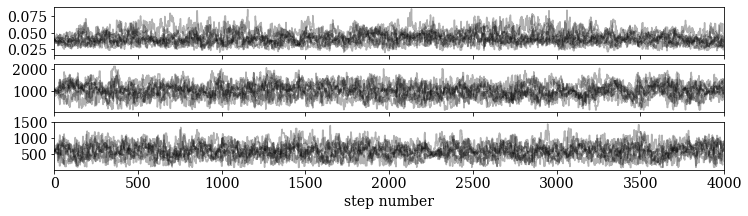

traj 1 of 8
est map [3.28221199e-02 7.19815551e+03 9.35116754e+02 1.04622211e+03] 4


100%|██████████| 4000/4000 [45:41<00:00,  1.46it/s]


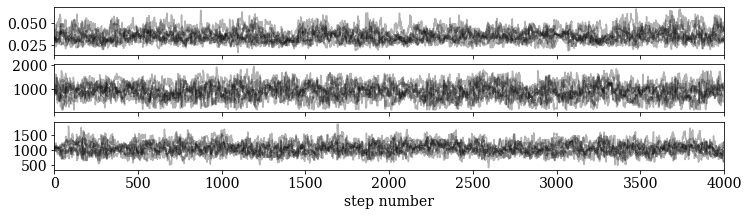

traj 2 of 8
est map [3.75945957e-02 7.22544033e+03 9.55073633e+02 7.00515110e+02] 4


100%|██████████| 4000/4000 [46:06<00:00,  1.45it/s]


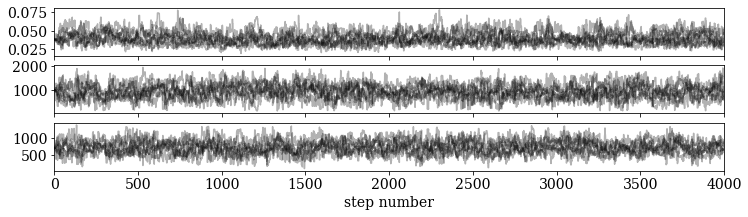

traj 3 of 8
est map [2.90830036e-02 7.15874586e+03 1.05121547e+03 8.00188031e+02] 4


100%|██████████| 4000/4000 [45:28<00:00,  1.47it/s]


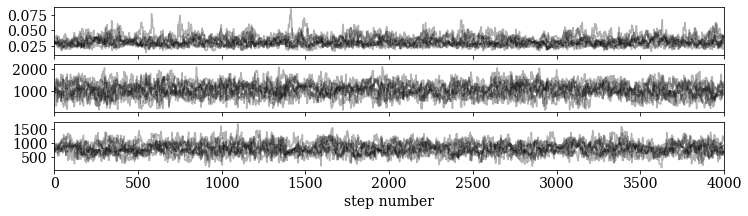

traj 4 of 8
est map [3.90330758e-02 7.18294460e+03 9.99224523e+02 7.47666633e+02] 4


100%|██████████| 4000/4000 [46:25<00:00,  1.44it/s]


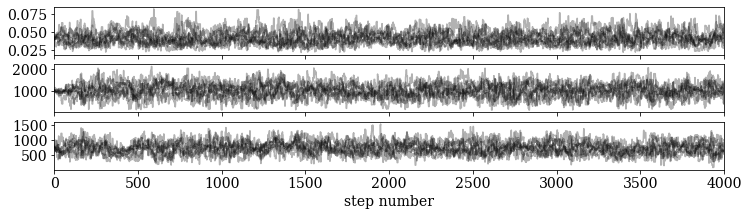

traj 5 of 8
est map [3.31007349e-02 7.22069002e+03 9.54015965e+02 6.73354227e+02] 4


100%|██████████| 4000/4000 [45:48<00:00,  1.46it/s]


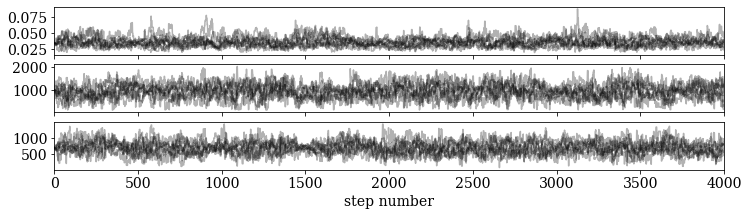

traj 6 of 8
est map [3.58342036e-02 7.18613573e+03 1.02955345e+03 8.40958605e+02] 4


100%|██████████| 4000/4000 [45:46<00:00,  1.46it/s]


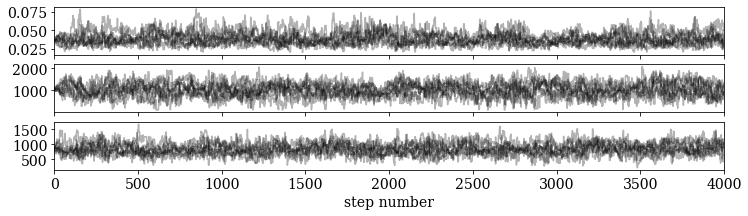

traj 7 of 8
est map [3.69050058e-02 7.20565857e+03 9.25526767e+02 7.52524591e+02] 4


100%|██████████| 4000/4000 [45:54<00:00,  1.45it/s]


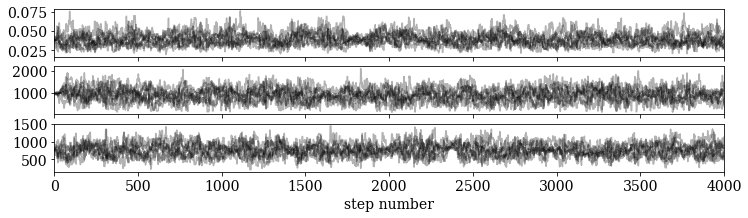

In [12]:
allResultsMC = []
for trajIndex,infResult in enumerate(allResultsInf) :
    print('traj',trajIndex,'of',len(allResultsInf))
    
    obsData = allData[ trajIndex ]
    
    sampler = synth_fns.do_mcmc(mcSamples, nProcMCMC, estimator, Tf_inference, infResult, 
                                obsData, fltrDeath, param_priors, init_priors, 
                                model_dict)
    plotMCtrace([0,2,3], sampler)
    result_mcmc = synth_fns.load_mcmc_result(estimator, obsData, fltrDeath, sampler, param_priors, init_priors, model_dict)
    allResultsMC += [result_mcmc]

### save MCMC data

In [13]:
opFile = fileRoot + "-mcmcAll.pik"
print('opf',opFile)
with open(opFile, 'wb') as f: 
    pickle.dump([allResultsInf,allResultsMC],f)

opf dataSynthInfQuality-pop1e4-mcmcAll.pik


In [14]:
for trajIndex,result_mcmc in enumerate(allResultsMC) :
    betas = [ rr['params_dict']['beta'] for rr in result_mcmc ]
    postMeanBeta = np.mean(betas)
    postStdBeta = np.std(betas)
    postCIBeta = [ np.percentile(betas,2.5) , np.percentile(betas,97.5)]

    #print("beta: true {b:.4f} MAP {m:.4f}".format(b=parameters_true['beta'],m=infResult['params_dict']['beta']))
    print("post: mean {m:.4f} std {s:.4f} CI95 {l:.4f} {u:.4f}".format(m=postMeanBeta,
                                                                     s=postStdBeta,
                                                                     l=postCIBeta[0],u=postCIBeta[1]))



post: mean 0.0420 std 0.0089 CI95 0.0278 0.0617
post: mean 0.0356 std 0.0067 CI95 0.0248 0.0504
post: mean 0.0393 std 0.0077 CI95 0.0268 0.0574
post: mean 0.0317 std 0.0073 CI95 0.0208 0.0479
post: mean 0.0417 std 0.0082 CI95 0.0279 0.0590
post: mean 0.0353 std 0.0068 CI95 0.0250 0.0525
post: mean 0.0386 std 0.0078 CI95 0.0272 0.0562
post: mean 0.0392 std 0.0075 CI95 0.0257 0.0562
